In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core import Backtest, PlotPoint, IStrategy
from IPython.core.display import display, HTML
import talib
from math import log
from tqdm.notebook import tqdm
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
class Jma_hard:
    def __init__(self, avg_len=65, jma_leng=12, phase_param=1, avg_vol_len=10):
        # first initialization
        self.avg_len = avg_len
        self.jma_leng = jma_leng
        self.phase_param = phase_param
        self.avg_vol_len = avg_vol_len
        self.len_0 = (jma_leng - 1) / 2
        self.len_1 = max(log(self.len_0) / (2 * log(2)) + 2, 0)
        self.len_2 = self.len_1 * (self.len_0 ** 0.5)
        self.beta_2 = self.len_2 / (self.len_2 + 1)
        self.kv = self.beta_2
        self.pow_1 = max(self.len_1 - 2, 0.5)
        self.beta = 0.45 *(self.jma_leng - 1) / (0.45 * (self.jma_leng - 1) + 2)
        self.alpha = self.beta
        #self.upper_band, self.lower_band, self.m1, self.m2, self.jma = test[0], test[0], test[0], test[0], test[0]
        self.initialized = False
        self.delta_1, self.delta_2, self.volty, self.v_sum, self.avg_volty, self.t0, self.t1 = 0, 0, 0, 0, 0, 0, 0
        self.r_volty, self.power = 1, 1
        self.volty_history = [0]
    
    
    def iterate_by_data(self, test):
        output = []
        for price in test:
            output.append(self.calc_jma(price))
        return output
            
    
    def calc_jma(self, price):
        if not self.initialized:
            self.initialized = True
            self.upper_band, self.lower_band, self.m1, self.m2, self.jma = price, price, price, price, price
        self.delta_1 = price - self.upper_band
        self.delta_2 = price - self.lower_band
        if abs(self.delta_1) == abs(self.delta_2):
            volty = 0
        else:
            volty = max(abs(self.delta_1), abs(self.delta_2))
        self.volty_history.append(volty)
        self.v_sum = np.array(self.volty_history[-10:]).mean()
        self.avg_volty = self.avg_volty + 2 * (self.v_sum - self.avg_volty) / (self.avg_len + 1)
        if self.avg_volty > 0:
            self.r_volty = max(min(volty / self.avg_volty, self.len_1 ** (1 / self.pow_1)), 1)
        else:
            self.r_volty = 1
        self.power = self.r_volty ** self.pow_1
        self.alpha = self.beta ** self.power
        self.kv = self.beta_2 ** (self.power ** 0.5)
        
        if self.delta_2 < 0:
            self.lower_band = price
        else:
            self.lower_band = price - self.kv * self.delta_2
        if self.delta_1 > 0:
            self.upper_band = price
        else:
            self.upper_band = price - self.kv * self.delta_1
            
        self.m1 = (1 - self.alpha) * price + self.alpha * self.m1
        self.t0 = (price - self.m1) * (1 - self.beta) + (self.beta * self.t0)
        self.m2 = self.m1 + self.t0 * self.phase_param
        self.t1 = (self.m2 - self.jma) * (1 - self.alpha) * (1 - self.alpha) + (self.alpha ** 2) * self.t1
        self.jma = self.jma + self.t1
        return self.jma


In [22]:
class Momentum(IStrategy):
    def __init__(self, symbol1, mom_span, ema_span, sell_or_buy = 0):
        self.ema = []
        self.mom = []
        self.price = []
        self.mom_span = mom_span
        self.ema_span = ema_span
        self.position = 0
        self.enter_price = None
        self.symbol1 = symbol1
        self.trades = []
        self.sell_or_buy = sell_or_buy
    def _update_ema(self, feeds):
        hard_jma = Jma_hard(jma_leng=self.ema_span, avg_len=65, phase_param=0.5, avg_vol_len=10)
        self.ema = hard_jma.iterate_by_data(feeds[self.symbol1].close)
        
    def _update_mom(self, feeds):
        self.mom = talib.MOM(np.array(feeds[self.symbol1].close), timeperiod=self.mom_span)
        self.mom = np.nan_to_num(self.mom) 
        
    def make_decision(self, feeds):        
        self.price.append((feeds[self.symbol1].close[-1])) 
        self._update_ema(feeds)
        self._update_mom(feeds)

        if len(feeds[self.symbol1]) < (max(self.mom_span, self.ema_span) + 5):
            return dict()

        if self.position == 1:
            if ((self.mom[-1] > 1) & (self.price[-1] > self.ema[-1])) | \
		((self.price[-1] > self.ema[-1]) & (self.price[-1] > self.ema[-2:-1][0])):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='exit_sell',
                    value=self.price[-1]
                ))                    
                return dict()
            else:
                return {self.symbol1: -1}
            
        elif self.position == -1:
            if ((self.mom[-1] < 1) & (self.price[-1] < self.ema[-1]))  | \
		((self.price[-1] < self.ema[-1]) & (self.price[-1] < self.ema[-2:-1][0])):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='exit_buy',
                    value=self.price[-1]
                ))  
                return dict()
            else:
                return {self.symbol1: 1}
        else:
            if (self.price[-1] < self.ema[-1]) & (self.price[-2:-1][0] < self.ema[-2:-1][0]) & \
		(self.mom[-1] < 0) & (np.array(self.mom[-5:-2]).mean() > 0) & (self.sell_or_buy <= 0):
                self.position = 1
                self.enter_price = self.price[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='enter_sell',
                    value=self.price[-1]
                ))
                return {self.symbol1: -1}
            
            elif (self.price[-1] > self.ema[-1]) & (self.price[-2:-1][0] > self.ema[-2:-1][0]) & \
		(self.mom[-1] > 0) & (np.array(self.mom[-5:-2]).mean() < 0) & (self.sell_or_buy >= 0):
                self.position = -1
                self.enter_price = self.price[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='enter_buy',
                    value=self.price[-1]
                ))
                return {self.symbol1: 1}            
            else:
                return dict()
    
    def get_plot_lines(self):
        return [
            {
                '{}'.format(self.symbol1): self.price,
                'ema span={}'.format(self.ema_span): self.ema
            },
            {
                'Mom span={}'.format(self.mom_span): self.mom
            }
        ]

    def get_plot_points(self):
        return [self.trades, []]

    def get_name(self):
        return 'Momentum {}, position={}'.format(self.symbol1, self.sell_or_buy)

In [17]:
data = pd.read_csv('BTCUSDT-15m-2021-03.csv')
data = data.rename({'45162.64':'Open', '45500.47':'High', '44972.49':'Low', '45498.26':'Close'}, axis=1)[['Open', 'High', 'Low', 'Close']]

In [28]:
data = pd.read_csv('BTCUSDT-15m-2021-04.csv')
data = data.rename({'58810.99':'Open', '59180.00':'High', '58799.23':'Low', '59044.53':'Close'}, axis=1)[['Open', 'High', 'Low', 'Close']]

-14349.054915999912

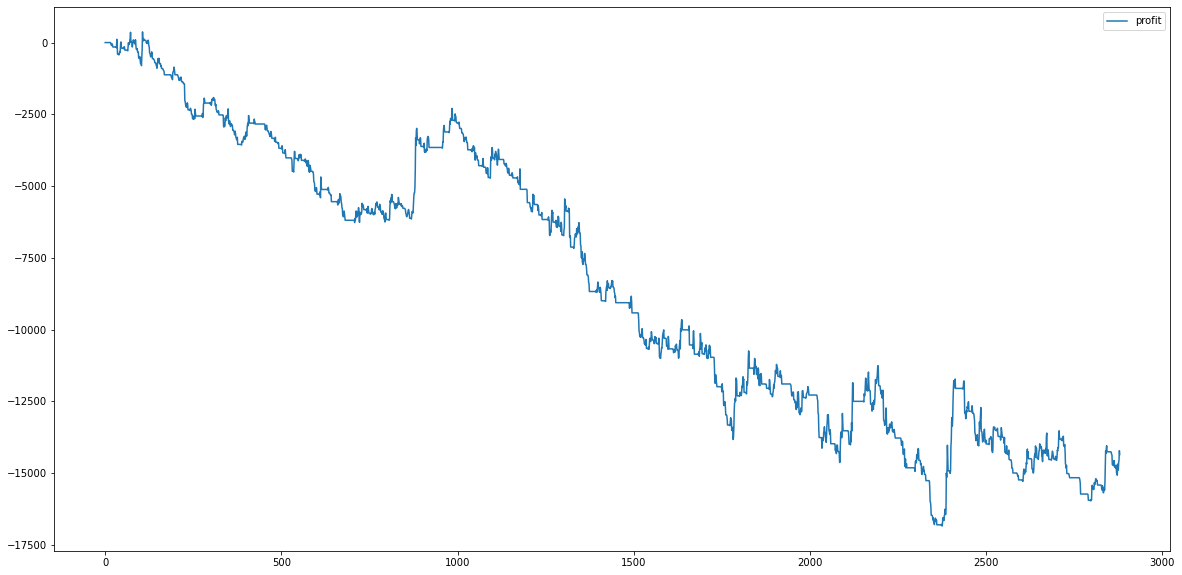

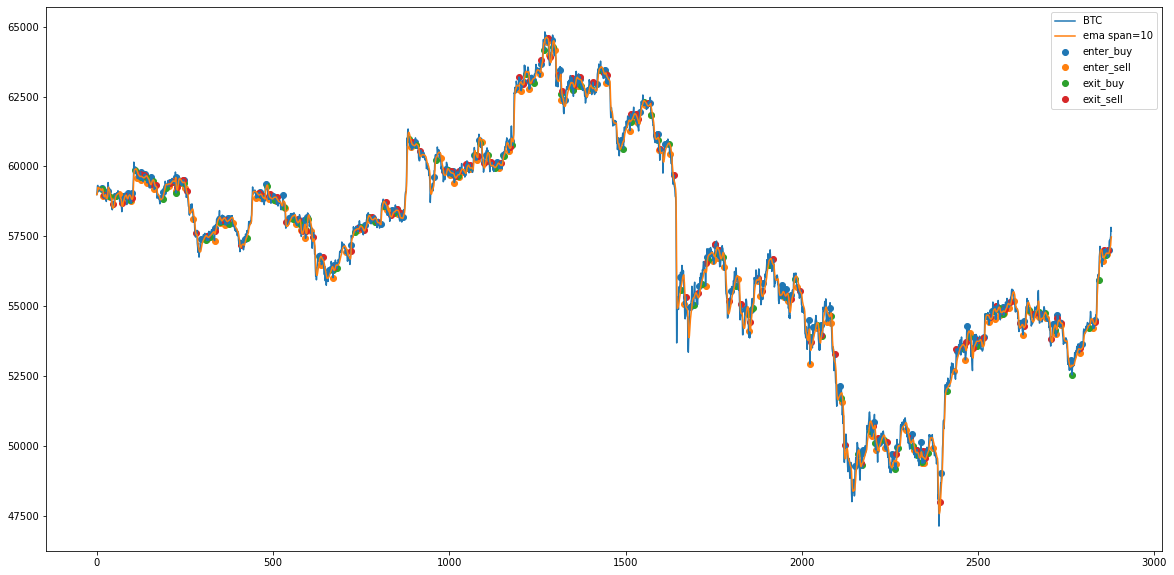

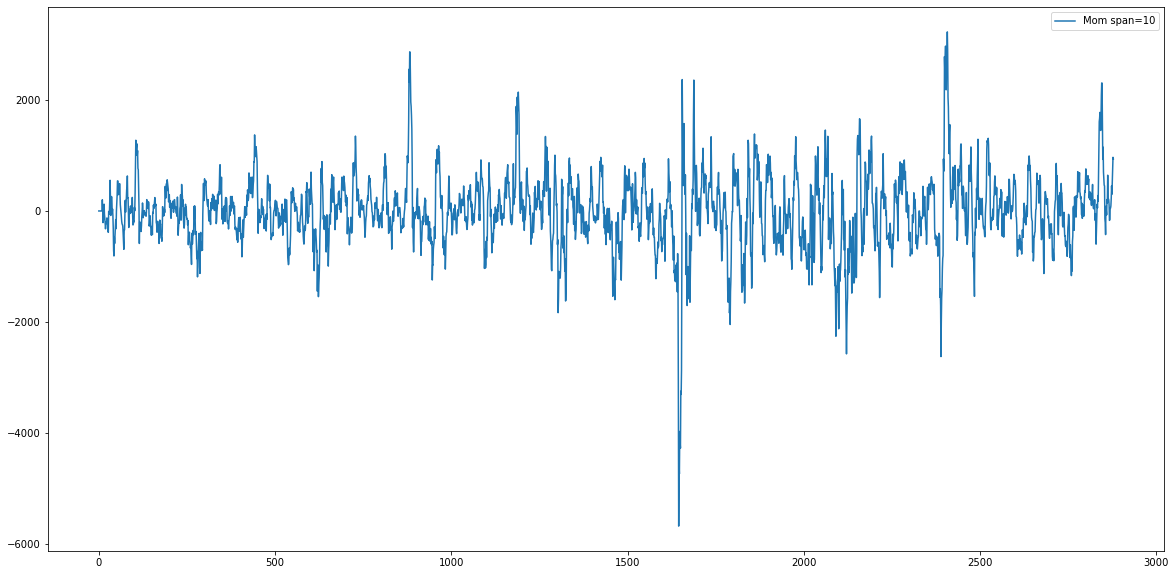

In [30]:
feeds = {
    'BTC': data,
}

strategy = Momentum('BTC',10, 10)
bt = Backtest(feeds, strategy)
bt.run(plot=True)['total_profit']

In [33]:
ii = []
jj = []

res = []
for i in tqdm(range(20, 50, 5)):
    for j in range(20, 50, 5):
        strategy = Momentum('BTC', i, j)
        bt = Backtest(feeds, strategy)
        res.append(bt.run(plot=False)['total_profit'])
        ii.append(i)
        jj.append(j)

In [34]:
pd.DataFrame({'ii':ii, 'jj':jj, 'res':res}).sort_values(by='res').tail(15)

,ii,jj,res
3,20,35,72.348204
32,45,30,148.408400
18,35,20,171.401224
31,45,25,205.559580
25,40,25,313.090672
16,30,40,667.414480
15,30,35,785.869460
30,45,20,1002.553624
17,30,45,1845.437680
27,40,35,2057.138212


In [26]:
pd.DataFrame({'ii':ii, 'jj':jj, 'res':res}).sort_values(by='res').tail(15)

,ii,jj,res
19,20,25,-6188.987124
8,10,20,-4214.319228
18,20,20,-3214.508636
7,10,15,-2656.357180
16,20,10,-2495.455748
1,5,10,-2273.922940
20,25,5,-327.961872
10,15,5,52.169528
11,15,10,826.993168
24,25,25,3152.235872
